## Problem 6 ##
Deliverable:
Given some data, predict how far a robot will throw a ball. Build a model and predict distance travelled (y, in meters), submitting predictions over a testing set as a csv file.

Hint: Range of a projectile on Wikipedia
$$
y = v \frac{\cos(\theta) }{g} (v\sin(\theta) + \sqrt{v^2 \sin(\theta) + 2gy_0})
$$

Where y = horizontal distance travelled, v = initial velocity, g =  $9.81 m/s^2$, $\theta$ = angle of launch, and y_0 is the initial height


In [ ]:
## Problem 6
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# load data
df = pd.read_csv("./midterm_data/data_train_midterm_problem6.csv")
test = pd.read_csv("./midterm_data/data_test_midterm_problem6.csv")

# EDA
df.describe()
df.head()

,y,x1,x2
0,0.748426,0.001797,45.559886
1,3.614964,0.013488,31.144537
2,1.573171,0.043075,11.400688
3,8.502541,0.045760,38.735018
4,7.402029,0.046383,35.208607


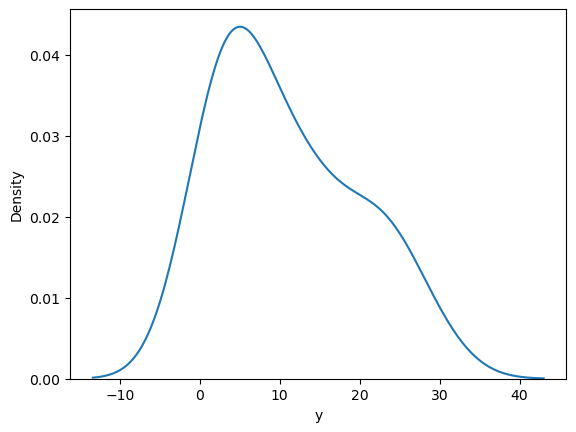

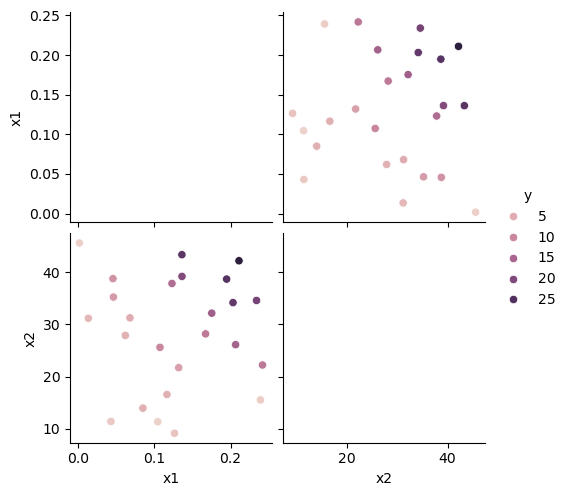

In [96]:
sns.kdeplot(df['y'])
sns.pairplot(df, vars=['x1', 'x2'], hue='y')
plt.show()

### Initial observations:
- y appears to increase relatively linearly with x1 and x2
- x1 and x2 have very different scales
- there is a decent amount of noise in the training set

We recall from the prompt that x1 corresponds to the initial velocity of the ball and the other corresponds to the starting angle. We would expect the distance of y at some point to be impeded by too high of an x2, but we can generally expect y to increase as a function of x1 (the initial velocity). Furthermore, since we are starting at ground level, the equation for the horizontal distance of a projectile can be rewritten as:

Also note that x1 = v from the previous equation and x2 = $\theta$
$$
y = \frac{{x_1}^2 \sin(2x_2)}{g} 
$$

We can further modify this for a probabilistic setting given the scatter plots we saw in exploratory data analysis by adding a term for gaussian noise, $\epsilon_i$:
$$
y = \frac{{x_1}^2 \sin(2x_2)}{g} + \epsilon_i \\
\text{where} \ \epsilon_i \sim \mathcal{N}(\mu, \sigma^2)
$$

First, I will try a regression approach with OLS and nonlinear basis functions to see how well I can fit the distribution of the training data, given that we know the data generation to be governed by a parabolic function. We can plot this "ideal function" with and without noise as follows:



In [97]:
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

# Fit bayesian regression 
X_train = df[['x1', 'x2']].values
y_train = df['y'].values
model = BayesianRidge()
model.fit(X_train, y_train)
y_pred, y_std = model.predict(X_train, return_std=True)

x_test = test[['x1', 'x2']].values
y_pred_test, y_std_test = model.predict(x_test, return_std=True)

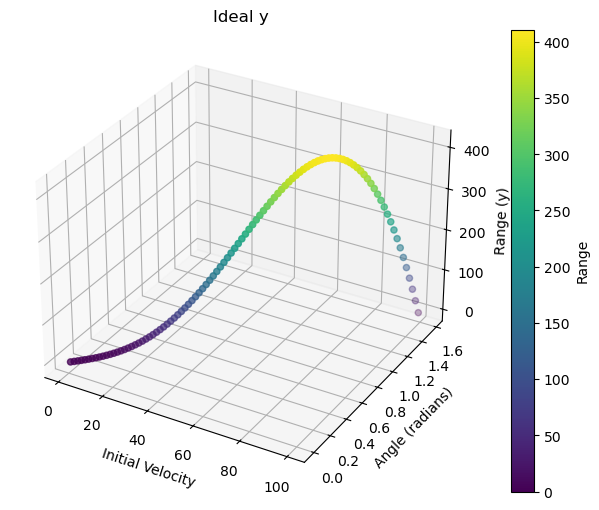

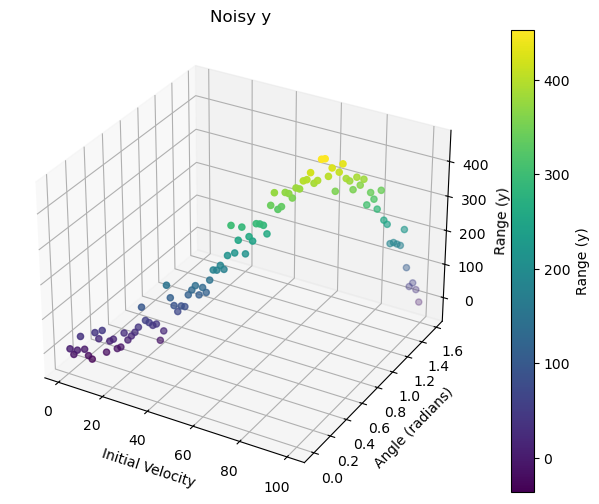

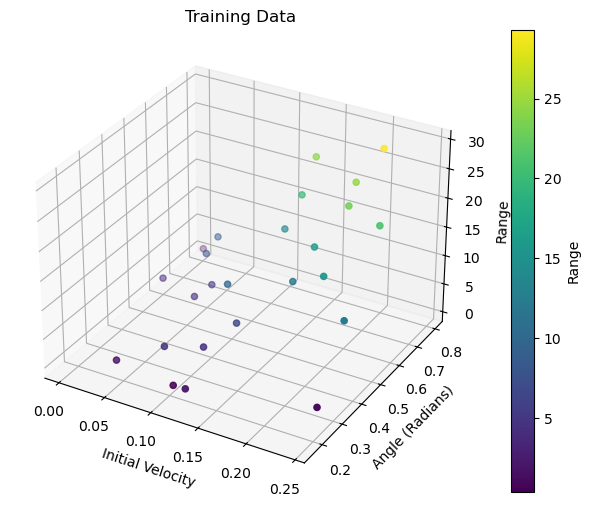

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## DEFINE DATA ##
grav = 9.8
mu = 0
sigma = 25
x1 = np.linspace(1, 100, 100) 
x2 = np.linspace(0, np.pi/2, 100)
y_ideal = (x1**2 * np.sin(2 * x2)) / grav
noise = np.random.normal(mu, sigma, size=y_ideal.shape)
y_noisy = y_ideal + noise
x1_train = df['x1'].values 
x2_train = np.radians(df['x2'].values)  
y_train = df['y'].values  

# PLOT
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x1, x2, y_ideal, c=y_ideal, cmap='viridis')
fig.colorbar(scatter, label='Range')
ax.set_xlabel('Initial Velocity')
ax.set_ylabel('Angle (radians)')
ax.set_zlabel('Range (y)')
plt.title('Ideal y')
plt.show()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x1, x2, y_noisy, c=y_noisy, cmap='viridis')
fig.colorbar(scatter, label='Range (y)')
ax.set_xlabel('Initial Velocity')
ax.set_ylabel('Angle (radians)')
ax.set_zlabel('Range (y)')
plt.title('Noisy y')
plt.show()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x1_train, x2_train, y_train, c=y_train, cmap='viridis')
fig.colorbar(scatter, label='Range')
ax.set_xlabel('Initial Velocity')
ax.set_ylabel('Angle (Radians)')
ax.set_zlabel('Range')
plt.title('Training Data')
plt.show()


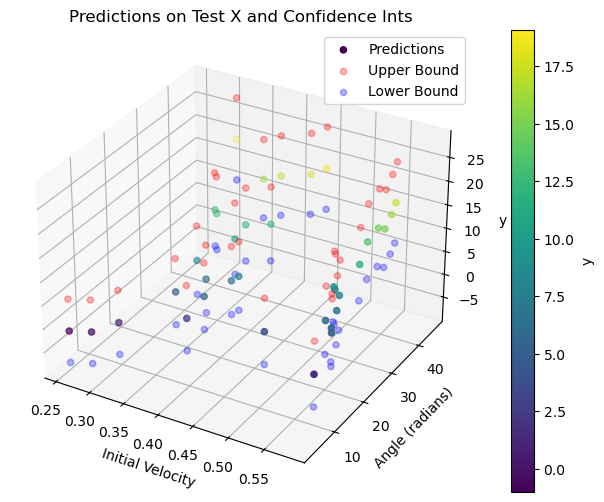

The MSE with the linear bayesian regression model is 44.371011251262104 and the MSE with the nonlinear bayesian regression model is 6.051112187575341


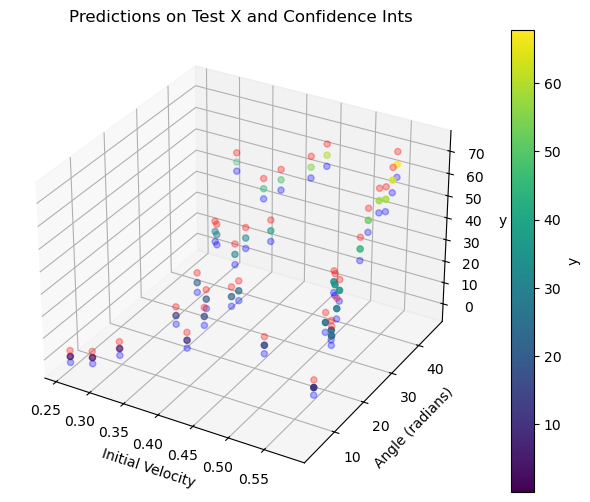

In [99]:
# load data
X_train = df[['x1', 'x2']].values
y_train = df['y'].values
X_test = test[['x1', 'x2']].values
x1_test = test[['x1']].values
x2_test = test[['x2']].values

# apply ridge model from above model
y_pred_train, y_std_train = model.predict(X_train, return_std=True)
y_pred_test, y_std_test = model.predict(X_test, return_std=True)

## PLOT ##
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x1_test, x2_test, y_pred_test, c=y_pred_test, cmap='viridis')
fig.colorbar(scatter, label='y')
ax.set_xlabel('Initial Velocity')
ax.set_ylabel('Angle (radians)')
ax.set_zlabel('y')
plt.title('Predictions on Test X and Confidence Ints')
y_upper_bound = y_pred_test + y_std_test
y_lower_bound = y_pred_test - y_std_test
ax.scatter(x1_test, x2_test, y_upper_bound, color='red', alpha=0.3, label='Upper Bound')
ax.scatter(x1_test, x2_test, y_lower_bound, color='blue', alpha=0.3, label='Lower Bound')
plt.legend(['Predictions', 'Upper Bound', 'Lower Bound'])
plt.show()

# calculate MSE on training set
mse_linear = mean_squared_error(y_train, y_pred_train)

##### ---------------------------------------------------------------------------------#####

## try with polynomial features - bayesian ridge regression with nonlinear basis functions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

poly = PolynomialFeatures(degree=2, include_bias=False)
model = make_pipeline(poly, BayesianRidge())
model.fit(X_train, y_train)

y_pred, y_std = model.predict(X_train, return_std=True)
y_pred_test, y_std_test = model.predict(X_test, return_std=True)

## PLOT ##
y_upper_bound = y_pred_test + y_std_test
y_lower_bound = y_pred_test - y_std_test
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x1_test, x2_test, y_pred_test, c=y_pred_test, cmap='viridis')
ax.scatter(x1_test, x2_test, y_upper_bound, color='red', alpha=0.3, label='Upper Bound')
ax.scatter(x1_test, x2_test, y_lower_bound, color='blue', alpha=0.3, label='Lower Bound')
fig.colorbar(scatter, label='y')
ax.set_xlabel('Initial Velocity')
ax.set_ylabel('Angle (radians)')
ax.set_zlabel('y')
plt.title('Predictions on Test X and Confidence Ints')

# calculate MSE on training set with nonlin model
mse_nonlinear = mean_squared_error(y_train, y_pred)

print(f"The MSE with the linear bayesian regression model is {mse_linear} and the MSE with the nonlinear bayesian regression model is {mse_nonlinear}")

In [100]:
x1_test = x1_test.flatten()
x2_test = x2_test.flatten()

#

df_results1 = pd.DataFrame({
    'x1': x1_test,
    'x2': x2_test,
    'y_pred_test': y_pred_test,
    'y_std_test': y_std_test
})

out = './sugarman_predictions_problem6.csv'
df_results1.to_csv(out, index=False)

## Refs

1. [ Nonlinear ridge regression](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
2. https://en.wikipedia.org/wiki/Range_of_a_projectile
3. 